# Anomaly detection Assignment

Anomaly detection is a technique for recognizing data points that differ significantly from the rest of the data in a dataset, and it uses past data or known knowledge to decide what is inside the expected range.  This method plays a crucial role in guaranteeing data quality and security across multiple domains.
Sensor dataset consists of 52 sensor units and records 7 system failures. An anomaly detection algorithm can learn the machine's normal behavior or expected patterns by analyzing sensor readings, operational parameters, and other relevant data. When a deviation from this normal behavior occurs, it may signal a potential failure or malfunction. The hypothesis is that a pump's sensor readings will show abnormal values prior to a failure, and these anomalies can be detected using anomaly detection techniques [Study Case: Anomaly Detection]


I have decided to contribute to the first and fourth options provided in the assignments list.  I would analyze the plot to evaluate the algorithm performance, assess the algorithm, evaluating the hypothesis. And also find the best configuration for the best selected model.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from anamoly import Anomaly
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm

# The data

In [2]:
# source: https://www.kaggle.com/datasets/nphantawee/pump-sensor-data
df = pd.read_csv('sensor.csv').drop('Unnamed: 0', axis=1)
df_origin = df.copy()

## Inspect data

In [3]:
df.shape

(220320, 54)

In [4]:
df.machine_status.value_counts()

machine_status
NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: count, dtype: int64

In [5]:
#missing values
percentage_missing = df.isnull().sum().sort_values(ascending=False)/len(df)*100
percentage_missing.head() # show 5 largest missing %

sensor_15    100.000000
sensor_50     34.956881
sensor_51      6.982117
sensor_00      4.633261
sensor_07      2.474129
dtype: float64

In [6]:
anomaly = Anomaly(df)
anomaly.df = anomaly.drop_nan_columns(nan_threshold=34)
anomaly.df = anomaly.df

                     sensor_00  sensor_01  sensor_02  sensor_03   sensor_04  \
timestamp                                                                     
2018-04-01 00:00:00   2.465394   47.09201  53.211800  46.310760  634.375000   
2018-04-01 00:01:00   2.465394   47.09201  53.211800  46.310760  634.375000   
2018-04-01 00:02:00   2.444734   47.35243  53.211800  46.397570  638.888900   
2018-04-01 00:03:00   2.460474   47.09201  53.168400  46.397568  628.125000   
2018-04-01 00:04:00   2.445718   47.13541  53.211800  46.397568  636.458300   
...                        ...        ...        ...        ...         ...   
2018-08-31 23:55:00   2.407350   47.69965  50.520830  43.142361  634.722229   
2018-08-31 23:56:00   2.400463   47.69965  50.564240  43.142361  630.902771   
2018-08-31 23:57:00   2.396528   47.69965  50.520830  43.142361  625.925903   
2018-08-31 23:58:00   2.406366   47.69965  50.520832  43.142361  635.648100   
2018-08-31 23:59:00   2.396528   47.69965  50.520832

We have dropped the columns which have data missing percentage value above or equal to 34. This way we removed the unrelated sensors.

## Visualization

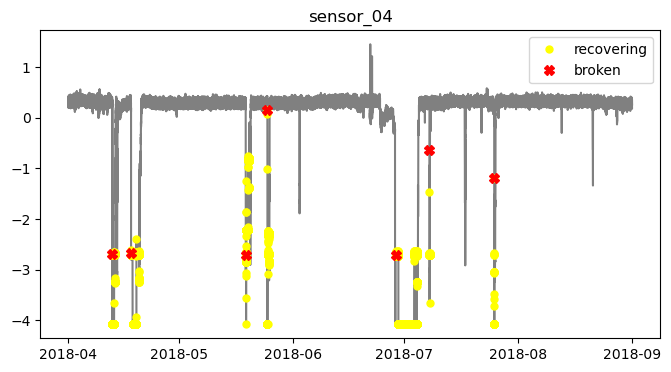

In [7]:
anomaly.plot_sensor(column='sensor_04')

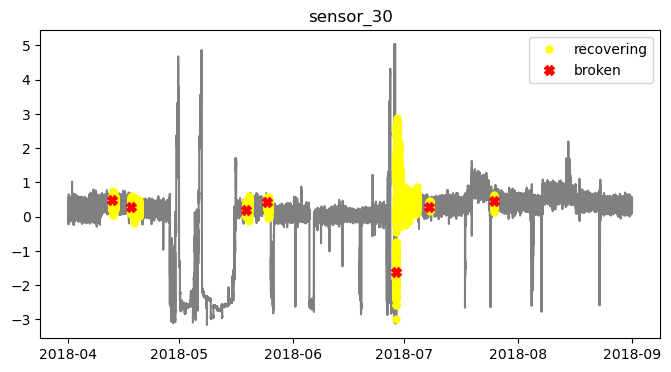

In [8]:
anomaly.plot_sensor(column='sensor_30')

/homes/rmeshita/miniconda3/envs/datascience_6/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


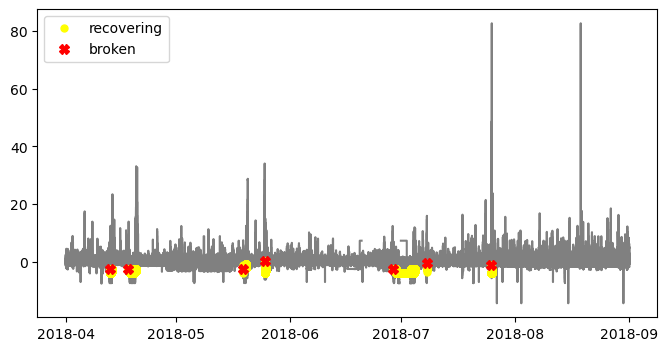

In [9]:
anomaly.plot_sensor()

From the plot visualization we could see that yellow reprents the recovering and red represents the broken status of the machine. When we see one single sensor like `sensor_04`, we see that lots of time machine is in recovering state. Some data are also missing for this sensor. 
For the `sensor_30` we see one huge chunk for machine recovery. when we plot all the sensors together, we could see when machine is broke in that time it is also trying to recovering. We need to do plot analysis to understand more about the data.

### Plot Analysis

We will look at the plot to see `IsolationForest`, `OneClassSVM`, `LocalOutlierFactor` and `EllipticEnvelope` detect anomalies in the data.

In [10]:
# We consider both "recovering" and "broken" states as anomalies / outliers.
# All the algorithms we use (IsolationForest, OneClassSVM, LocalOutlierFactor, and EllipticEnvelope) 
# return +1 for normal points and -1 for anomalies, so this matches our approach.
# After a "broken" status, the machine tries to recover, but it’s not fully functional yet. 
# We had two choices: treat "recovering" as normal or as anomaly. 
# I chose to consider it as broken because that seems more reasonable, 
# since the machine is still not operating normally.

outliers_fraction = 1 - (df['machine_status'].value_counts()['NORMAL']/len(df))
outliers_fraction

np.float64(0.06574074074074077)

In [31]:
# model declaration with parameters

isolation_forest = IsolationForest(contamination=outliers_fraction, n_jobs = -1)
svm_one_class = svm.OneClassSVM(nu=outliers_fraction)
local_outliner = LocalOutlierFactor(contamination=outliers_fraction, n_jobs = -1)
robust_covariance = EllipticEnvelope(contamination=outliers_fraction)

#### Isolation Forest

In [12]:
anomaly.return_target() # 0 = normal and 1 = anomaly

timestamp
2018-04-01 00:00:00    1
2018-04-01 00:01:00    1
2018-04-01 00:02:00    1
2018-04-01 00:03:00    1
2018-04-01 00:04:00    1
                      ..
2018-08-31 23:55:00    1
2018-08-31 23:56:00    1
2018-08-31 23:57:00    1
2018-08-31 23:58:00    1
2018-08-31 23:59:00    1
Name: machine_status, Length: 220320, dtype: int64

In [13]:
X_train, X_test, y_train, y_test = anomaly.split_train_test()
X_train, X_test, y_train, y_test

(array([[ 2.38780265e-01,  6.52106564e-01,  9.48761070e-02, ...,
         -7.75709423e-01, -4.14271788e-01, -1.00343275e+00],
        [ 2.16786211e-01,  3.88571471e-01,  7.69597540e-01, ...,
         -3.35909951e-01, -4.59619424e-01, -1.45105424e-03],
        [ 6.03810161e-02, -6.26036932e-01,  4.61829199e-01, ...,
          9.41267143e-01,  5.22905766e-01,  5.33016922e-02],
        ...,
        [ 0.00000000e+00, -3.81480491e+00, -3.68117724e+00, ...,
         -1.44772293e+00, -1.32121836e+00,  7.54352566e+00],
        [ 3.26758963e-01, -1.40346276e+00, -3.66770950e-01, ...,
         -7.20301952e-02,  1.32404173e+00,  6.19996876e-01],
        [-8.70719631e-01,  7.04812516e-01,  6.51224510e-01, ...,
         -6.31455180e-01, -4.74735008e-01,  2.68907318e-16]]),
 array([[ 0.31698162, -0.15167454, -0.37861008, ..., -0.84959573,
         -0.38404044, -0.12464521],
        [ 0.32675896, -0.28344093, -0.08267815, ...,  0.47683955,
         -0.38404044, -0.18213606],
        [ 0.34386435, -0.

In [14]:
y_test

timestamp
2018-06-15 02:25:00    1
2018-08-08 00:59:00    1
2018-07-14 14:48:00    1
2018-08-29 14:38:00    1
2018-08-17 18:13:00    1
                      ..
2018-05-21 05:49:00    1
2018-07-02 09:11:00   -1
2018-06-07 15:14:00    1
2018-05-12 06:29:00    1
2018-07-19 10:43:00    1
Name: machine_status, Length: 44064, dtype: int64

1.0


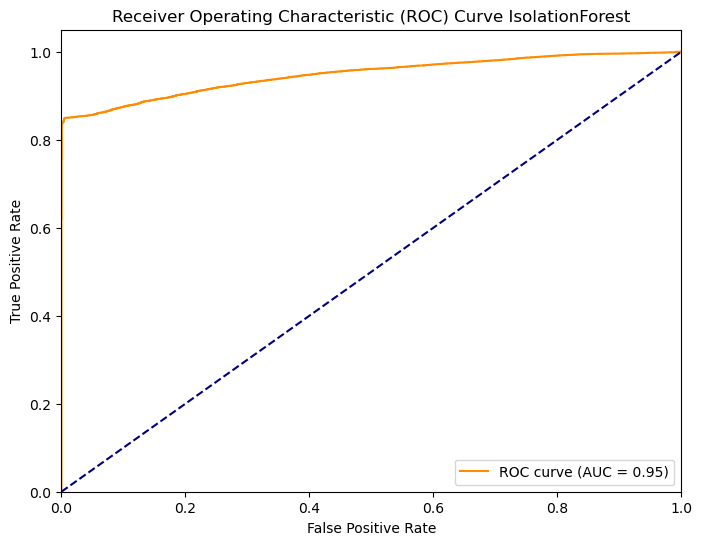

In [15]:
anomaly.plot_auc_isolation_forest(isolation_forest, X_train, y_test, X_test)

1.0


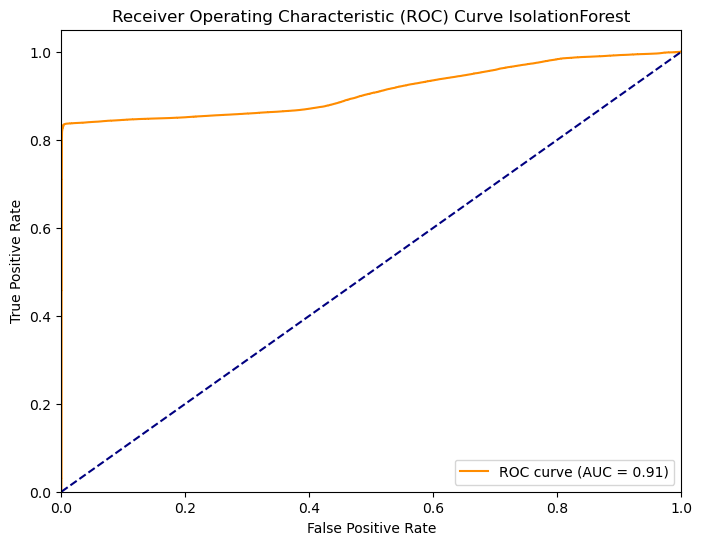

In [16]:
anomaly.plot_auc_isolation_forest(isolation_forest, anomaly.X, anomaly.return_target())

In [17]:
y_preds = anomaly.anomaly_detection(isolation_forest)
y_preds

array([1, 1, 1, ..., 1, 1, 1])

In [18]:
y = anomaly.return_target()
y.value_counts()

machine_status
 1    205836
-1     14484
Name: count, dtype: int64

              precision    recall  f1-score   support

     Anomaly       0.42      0.42      0.42     14484
      Normal       0.96      0.96      0.96    205836

    accuracy                           0.92    220320
   macro avg       0.69      0.69      0.69    220320
weighted avg       0.92      0.92      0.92    220320



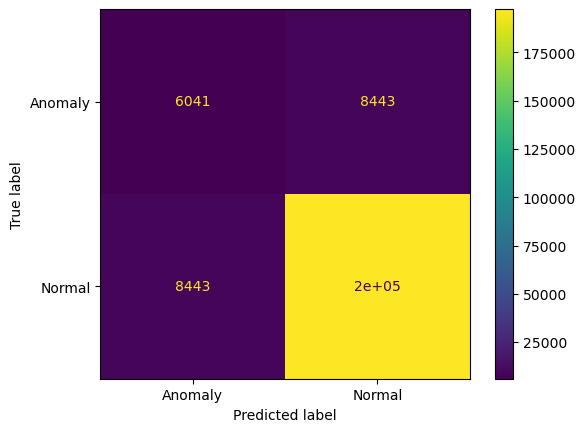

In [19]:
anomaly.evaluation(y_preds)

In [20]:
y_preds_split = anomaly.anomaly_detection_with_train_test(isolation_forest,X_train,X_test)

y_preds_split

array([ 1,  1,  1, ...,  1, -1,  1])

              precision    recall  f1-score   support

     Anomaly       0.49      0.49      0.49      2821
      Normal       0.97      0.97      0.97     41243

    accuracy                           0.94     44064
   macro avg       0.73      0.73      0.73     44064
weighted avg       0.94      0.94      0.94     44064



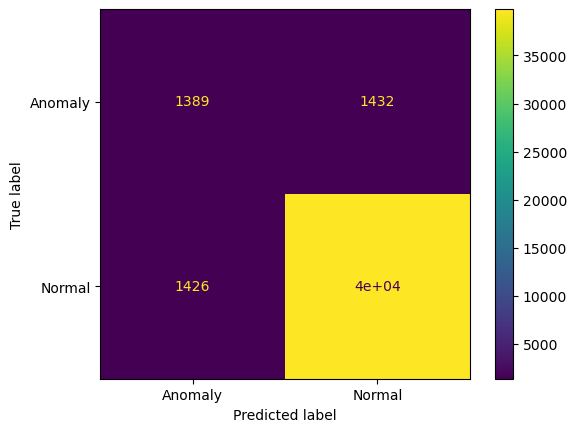

In [24]:
anomaly.evaluation(y_preds_split,y_test)

In [21]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve, auc
# import re

# def plot_auc_isolation_forest(model,dataframe, y):
    
#     m, n = dataframe.shape
#     X = dataframe.iloc[:,:n-1] # ignore machine status columns
#     X = X.fillna(X.mean()) # we can use last point as missing values
#     model.fit(X)
#     model_name = str(model).split('(')[0]
#     if str(model).startswith('LocalOutlierFactor'):
#         y_scores = - model.negative_outlier_factor_
        
#     elif str(model).startswith('IsolationForest'):
#        y_scores = - model.decision_function(X)
#     elif str(model).startwith('OneClassSVM'):
#         y_scores= - model.decision_function(X)
#     elif str(model).startswith('EllipticEnvelope'):
#         y_scores= - model.decision_function(X)
        
#     y = anomaly.return_target()
#     fpr, tpr, thresholds = roc_curve(y, y_scores)
#     roc_auc = auc(fpr, tpr)
#     print(max(fpr))
#     plt.figure(figsize=(8, 6))
#     plt.plot(fpr, tpr, color='darkorange', 
#                 label=f'ROC curve (AUC = {roc_auc:.2f})')
#     plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('Receiver Operating Characteristic (ROC) Curve {model_name}')
#     plt.legend(loc="lower right")
#     plt.show()
#         # anomaly score
    
    

In [14]:
model = isolation_forest

if str(model).startswith('LocalOutlierFactor'):
    print('model is true')
else: print("False")

False


In [15]:
isolation_forest_preds = anomaly.anomaly_detection(isolation_forest)

1.0


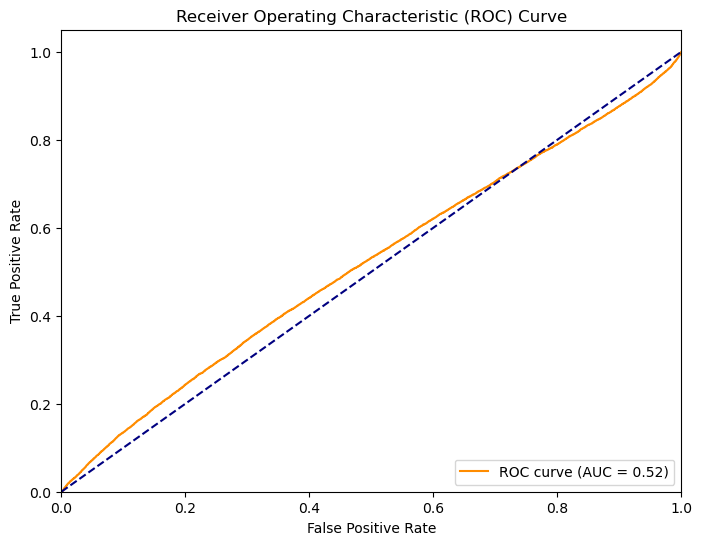

In [20]:
df = anomaly.df
m, n = df.shape
X = df.iloc[:,:n-1] # ignore machine status columns
X = X.fillna(X.mean()) # we can use last point as missing values
local_outliner.fit(X)
y_scores = - local_outliner.negative_outlier_factor_

y = anomaly.return_target()
fpr, tpr, thresholds = roc_curve(y, y_scores)
roc_auc = auc(fpr, tpr)
# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', 
            label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


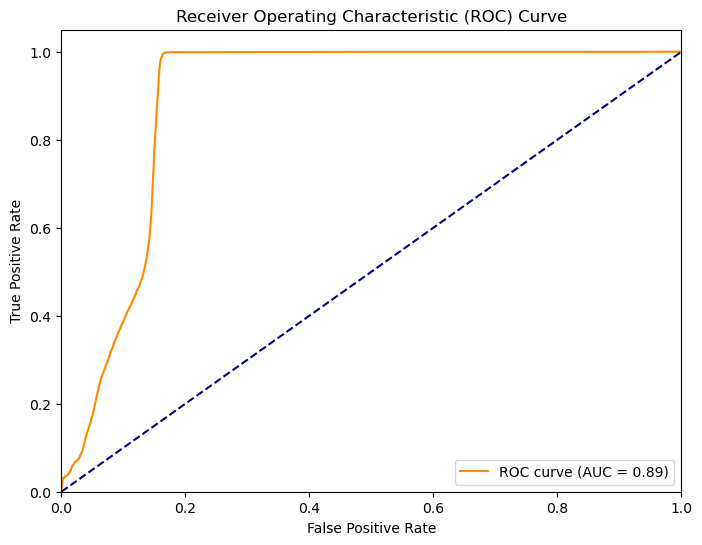

In [17]:
df = anomaly.df
m, n = df.shape
X = df.iloc[:,:n-1] # ignore machine status columns
X = X.fillna(X.mean()) # we can use last point as missing values
isolation_forest.fit(X)
y_scores = - isolation_forest.decision_function(X)
y = anomaly.return_target()
fpr, tpr, thresholds = roc_curve(y, y_scores)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', 
            label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


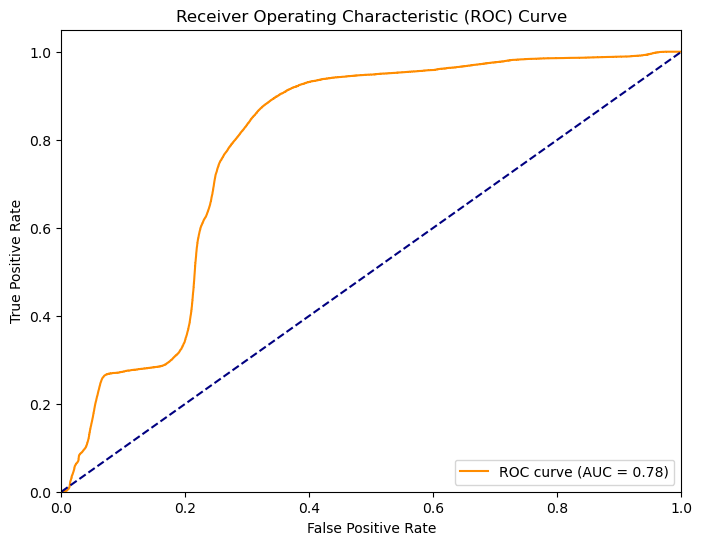

In [18]:
# svm
df = anomaly.df
m, n = df.shape
X = df.iloc[:,:n-1] # ignore machine status columns
X = X.fillna(X.mean()) # we can use last point as missing values
svm_one_class.fit(X)
y_scores = - svm_one_class.decision_function(X)
y = anomaly.return_target()
fpr, tpr, thresholds = roc_curve(y, y_scores)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', 
            label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

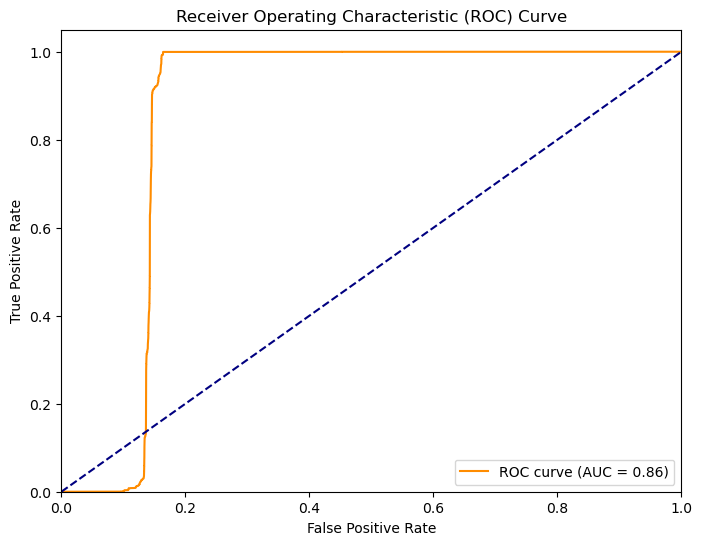

In [19]:
# svm
df = anomaly.df
m, n = df.shape
X = df.iloc[:,:n-1] # ignore machine status columns
X = X.fillna(X.mean()) # we can use last point as missing values
robust_covariance.fit(X)
y_scores = - robust_covariance.decision_function(X)
y = anomaly.return_target()
fpr, tpr, thresholds = roc_curve(y, y_scores)
roc_auc = auc(fpr, tpr)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', 
            label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

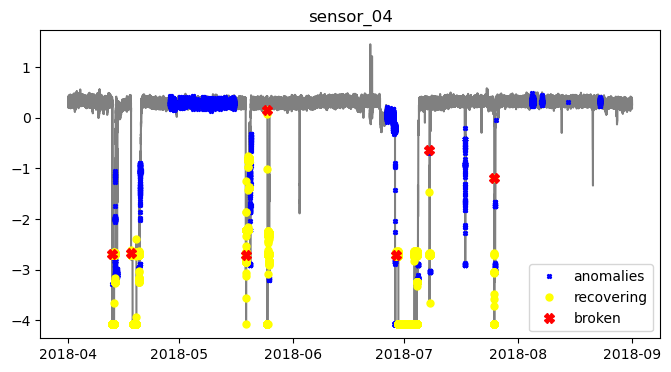

In [ ]:
anomaly.plot_sensor(column = 'sensor_04',preds=isolation_forest_preds)

/homes/rmeshita/miniconda3/envs/datascience_6/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


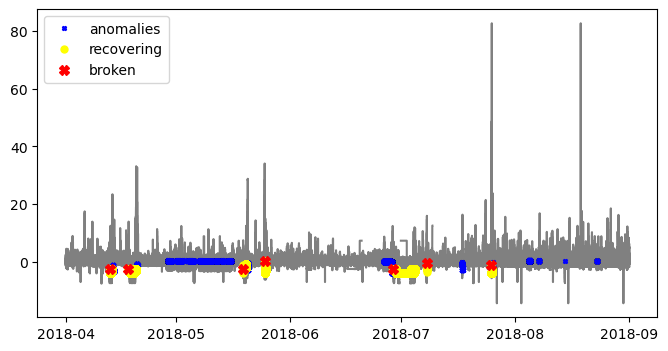

In [ ]:
anomaly.plot_sensor(preds=isolation_forest_preds)

              precision    recall  f1-score   support

     Anomaly       0.44      0.44      0.44     14484
      Normal       0.96      0.96      0.96    205836

    accuracy                           0.93    220320
   macro avg       0.70      0.70      0.70    220320
weighted avg       0.93      0.93      0.93    220320



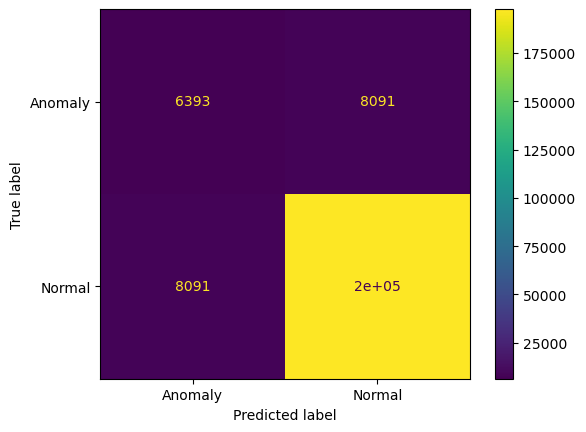

In [ ]:
anomaly.evaluation(isolation_forest_preds)

Anomaly predictions are not great. The model predict anomalies at places where machine was normal

In [ ]:
def calculate_anomaly_detection_auc(model, )

#### SVM One Class

In [ ]:
svm_one_class_preds = anomaly.anomaly_detection(svm_one_class)

In [ ]:
svm_one_class_preds

array([1, 1, 1, ..., 1, 1, 1])

/homes/rmeshita/miniconda3/envs/datascience_6/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


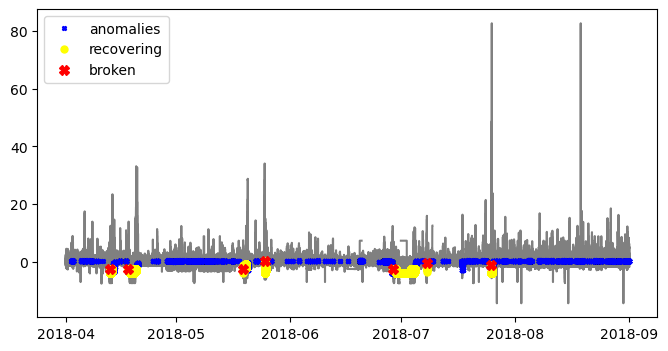

In [ ]:
anomaly.plot_sensor(preds=svm_one_class_preds)

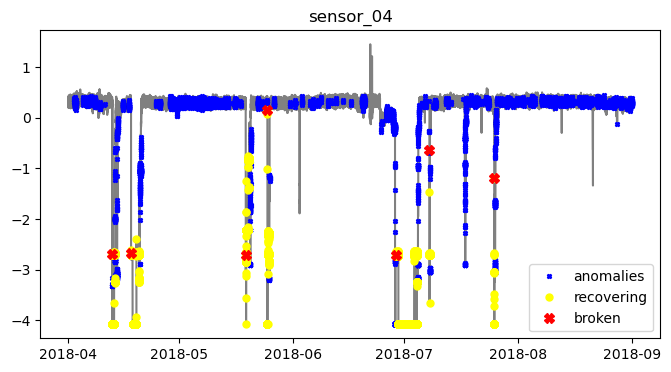

In [ ]:
anomaly.plot_sensor(column = 'sensor_04',preds=svm_one_class_preds)

              precision    recall  f1-score   support

     Anomaly       0.42      0.42      0.42     14484
      Normal       0.96      0.96      0.96    205836

    accuracy                           0.92    220320
   macro avg       0.69      0.69      0.69    220320
weighted avg       0.92      0.92      0.92    220320



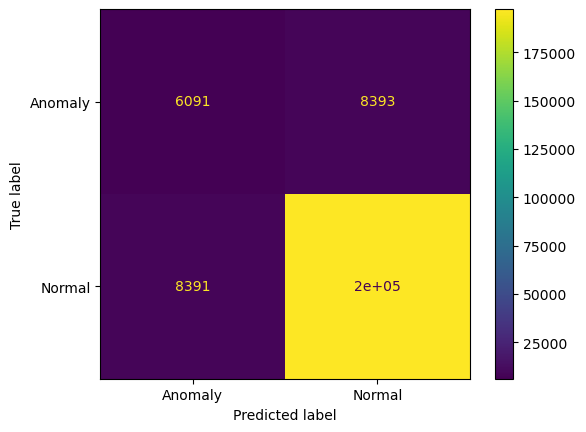

In [ ]:
anomaly.evaluation(svm_one_class_preds)

Anomaly predictions are worse than Isolation Model. The model predict anomalies at places where machine was normal

#### Local Outlier Factor

In [ ]:
local_outliner_preds = anomaly.anomaly_detection(local_outliner, local_outlier=True):


/homes/rmeshita/miniconda3/envs/datascience_6/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


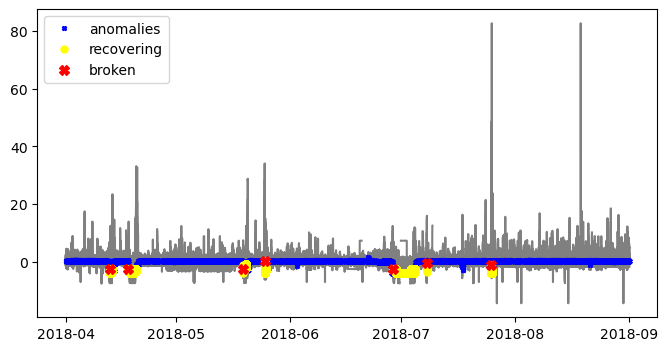

In [ ]:
anomaly.plot_sensor(preds=local_outliner_preds)

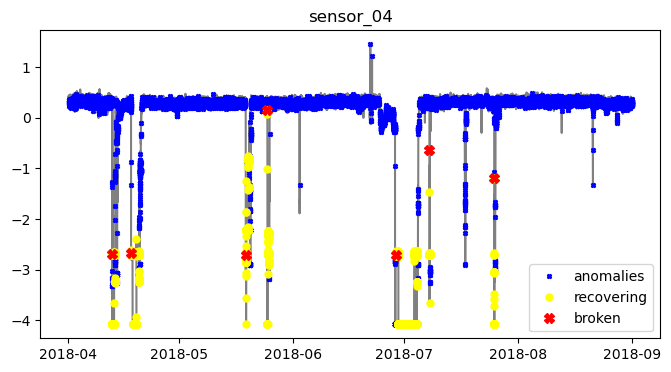

In [ ]:
anomaly.plot_sensor(column = 'sensor_04',preds=local_outliner_preds)

              precision    recall  f1-score   support

     Anomaly       0.16      0.16      0.16     14484
      Normal       0.94      0.94      0.94    205836

    accuracy                           0.89    220320
   macro avg       0.55      0.55      0.55    220320
weighted avg       0.89      0.89      0.89    220320



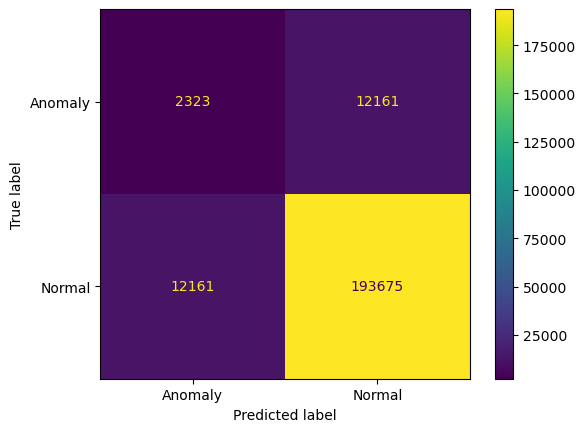

In [ ]:
anomaly.evaluation(local_outliner_preds)

The model picked most of the data points as anomaly.

#### Robust covariance

In [ ]:
robust_covariance_preds = anomaly.anomaly_detection(robust_covariance)

/homes/rmeshita/miniconda3/envs/datascience_6/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


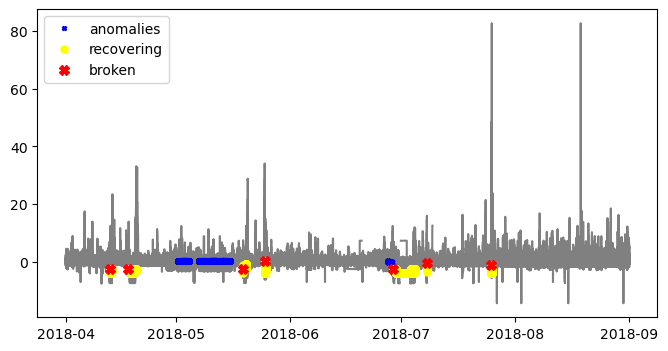

In [ ]:
anomaly.plot_sensor(preds=robust_covariance_preds)

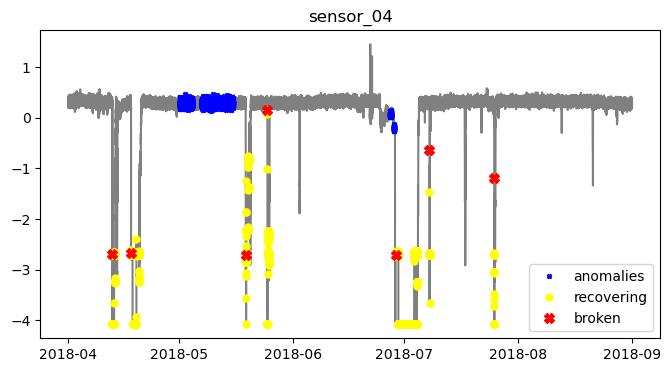

In [ ]:
anomaly.plot_sensor(column = 'sensor_04',preds=robust_covariance_preds)

              precision    recall  f1-score   support

     Anomaly       0.00      0.00      0.00     14484
      Normal       0.93      0.93      0.93    205836

    accuracy                           0.87    220320
   macro avg       0.46      0.46      0.46    220320
weighted avg       0.87      0.87      0.87    220320



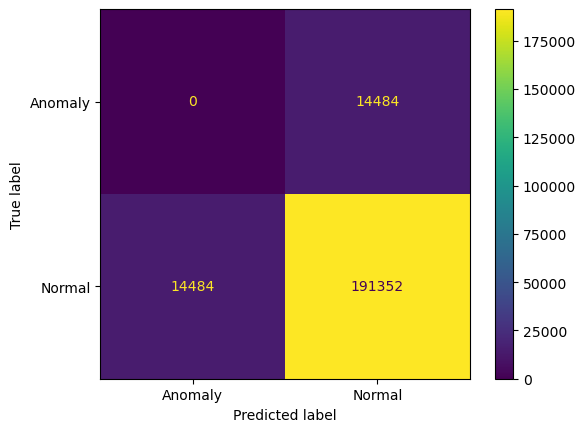

In [ ]:
anomaly.evaluation(robust_covariance_preds)

Predicts anomalies at wrong places

Based on the F1 scores, the **One-Class SVM** model exhibited scattered predictions, yet it successfully identified some anomalies despite its dispersed nature. In contrast, the **Robust Covariance** model produced highly concentrated predictions, but these were largely confined to non-anomalous regions, resulting in poor anomaly detection. The **Local Outlier Factor** model also delivered scattered predictions, but with significantly lower accuracy, reflected in its poor F1 score. Meanwhile, the **Isolation Forest** model identified anomalies in clusters, achieving the same F1 score as the **One-Class SVM**, indicating a comparable but more localized anomaly detection performance.

##### comparison between outputs of SVM and Robust covariance

In [ ]:
anomaly.df['One-Class SVM'] = svm_one_class_preds
svm_ = anomaly.df[anomaly.df['One-Class SVM']==-1]['sensor_05'].index

In [ ]:
anomaly.df['Robust covariance'] = robust_covariance_preds
rc = anomaly.df[anomaly.df['Robust covariance']==-1]['sensor_05'].index

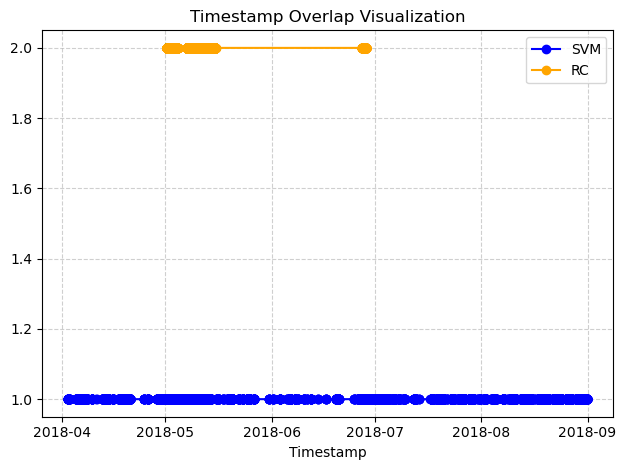

In [ ]:
import matplotlib.dates as mdates
plt.plot(svm_, [1] * len(svm_), 'o-', label='SVM', color='blue')

# Plot second array
plt.plot(rc, [2] * len(rc), 'o-', label='RC', color='orange')

# Formatting
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel("Timestamp")
plt.title("Timestamp Overlap Visualization")
plt.legend()
plt.tight_layout()
plt.show()

## False Positive Mitigation

We observed that some sensors displayed deviations from normal behavior, although the machine was operating normally during those periods. These predictions are false positives. False positives are common phenomenon in anomaly detection. Several technieques have been suggested by earlier research on how to mitigate false positives. The paper [https://ieeexplore.ieee.org/document/8516611] proposes mitigating false positives in anomaly detection for behavioral malware detection by using deep learning models combined with adversarial training and confidence-based filtering to improve detection accuracy. On the other hand, The paper [https://www.sciencedirect.com/science/article/pii/S1566253523002737?ref=pdf_download&fr=RR-2&rr=91993aef99023581] proposes mitigating false positives in time series anomaly detection by using a two-stage methodology: the first stage detects anomalies using a multivariate anomaly detector, while the second stage trains a separate classifier on the anomaly detector's outputs to distinguish between true and false positives, refining the final anomaly labels.

In this assignment, we focused solely on classical machine learning algorithms for anomaly detection. Therefore, we opted for **manual plot analysis** to investigate potential data irregularities that might contribute to the elevated rate of false positives.

sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09


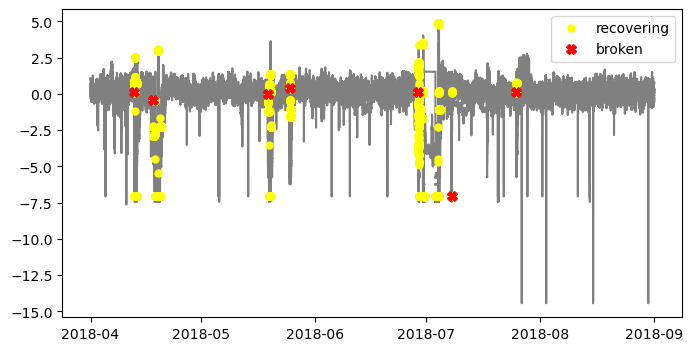

sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20


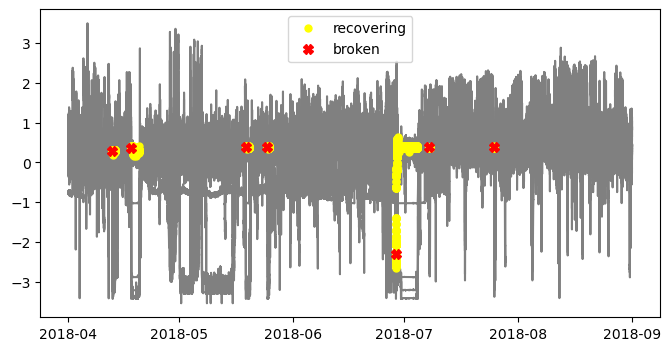

sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30


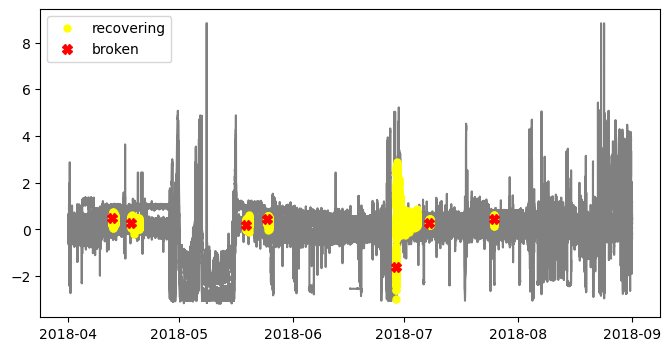

sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40


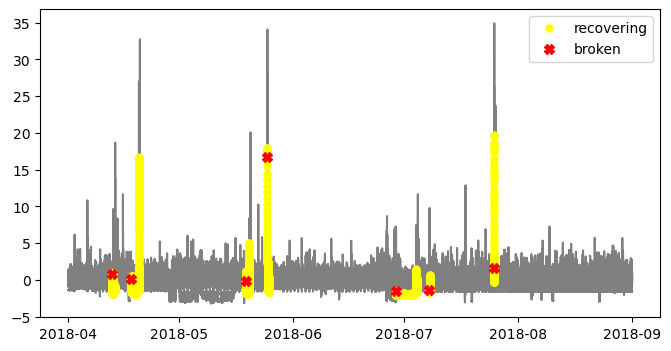

sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51


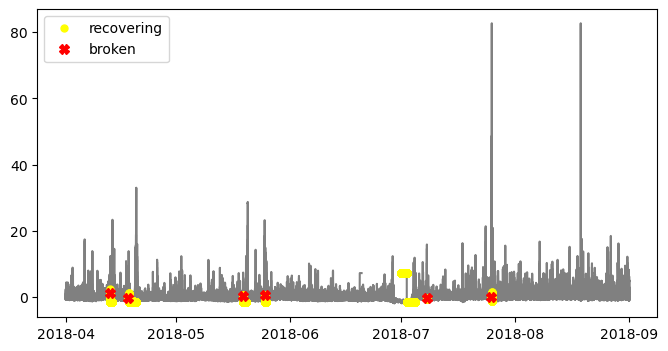

In [21]:
sensors = [sensor for sensor in anomaly.df.columns if sensor.startswith('sensor')]
for i in range(0,len(sensors),10):
    print(",".join(sensors[i:i+10]))
    anomaly.plot_sensor(column=sensors[i:i+10])

We could see a clear deviation when plot sensors 20-29, also we found few sensors from 10-15 are deviated. 

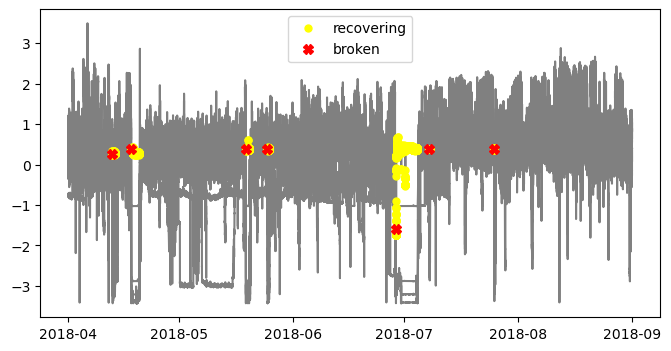

In [ ]:

anomaly.plot_sensor(column=sensors[10:15])

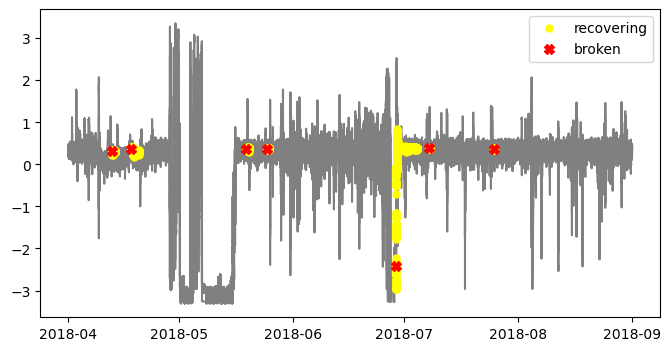

In [ ]:
anomaly.plot_sensor(column=sensors[16:20])

15-20 sensors clearly displayes deviation

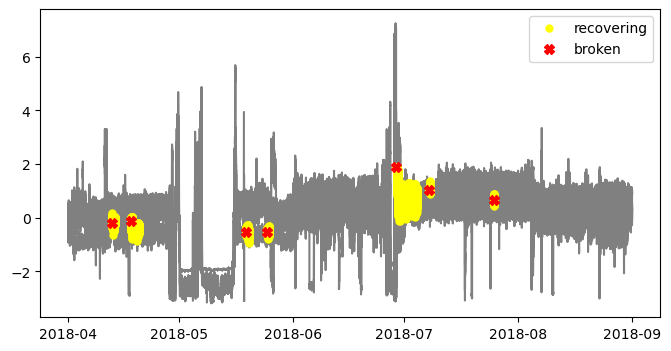

In [ ]:
anomaly.plot_sensor(column=sensors[30:36])

30-36 sensors clearly displayes deviation

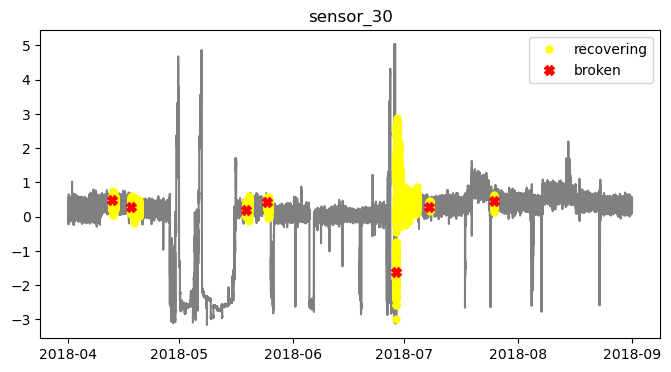

In [ ]:
anomaly.plot_sensor(column='sensor_30')

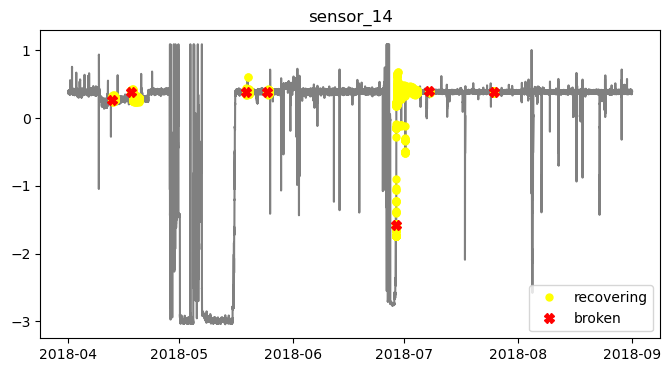

In [ ]:
anomaly.plot_sensor(column='sensor_14')

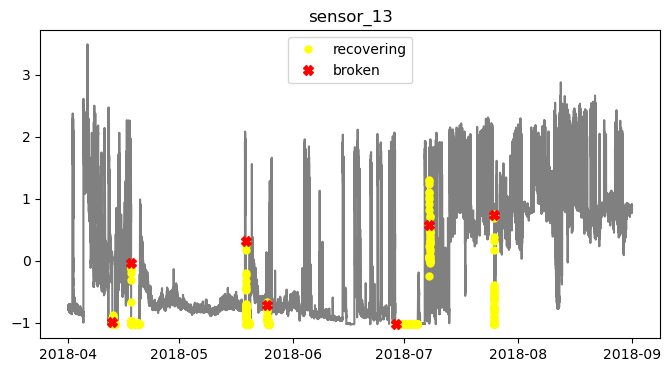

In [ ]:
anomaly.plot_sensor(column='sensor_13')

This signal is also unreliable since it shows two different patter over time

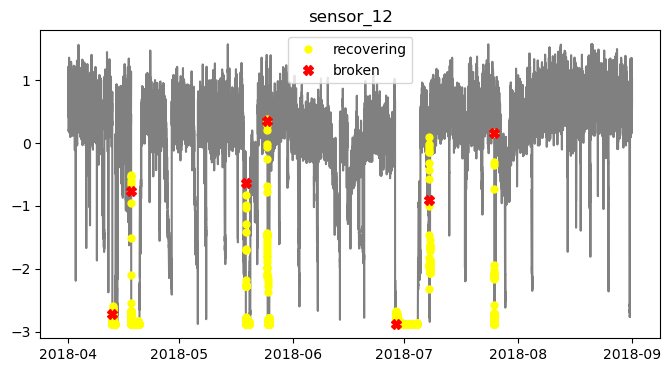

In [ ]:
anomaly.plot_sensor(column='sensor_12')

It seems reliable the abonormality follows the deviation of the pattern

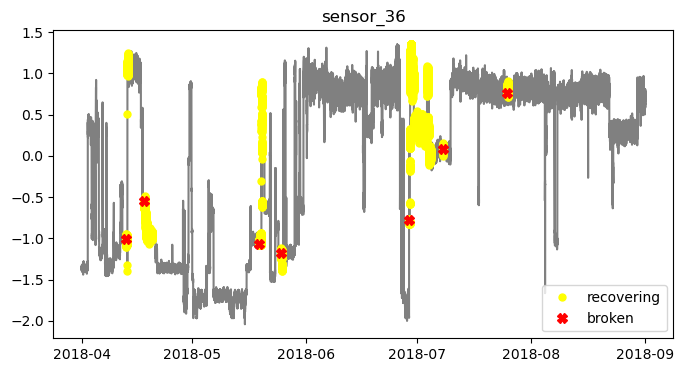

In [ ]:
anomaly.plot_sensor(column='sensor_36')

clear deviation without any breakdwon makes it unreliable

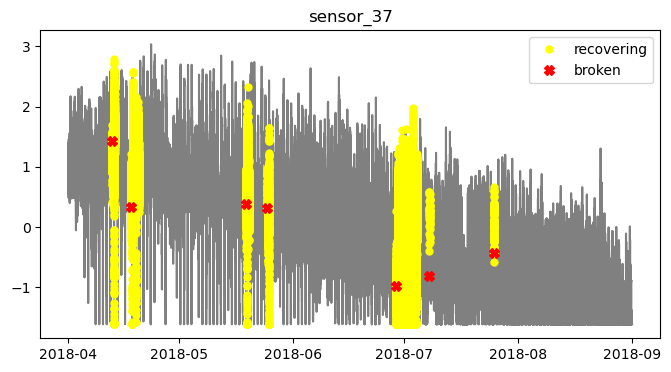

In [ ]:
anomaly.plot_sensor(column='sensor_37')

The signal has high variance this makes it harder to distinguish real anomalies from random fluctuations.

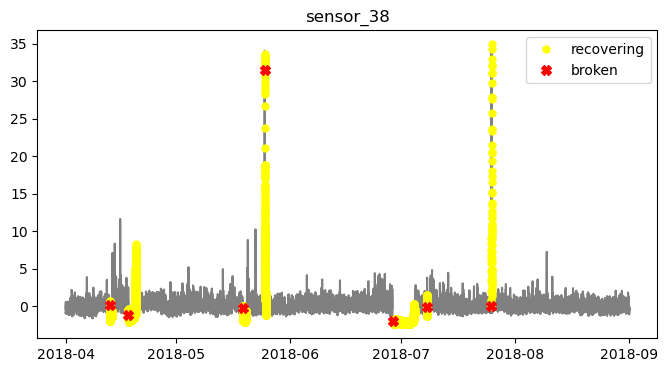

In [ ]:
anomaly.plot_sensor(column='sensor_38')

The signal seems reliable

Based on our analysis, we decided to remove following sensors to experiment, if the removal of sensors make anomaly detection more efficient and reliable

In [26]:
sensors[13:38]

['sensor_13',
 'sensor_14',
 'sensor_16',
 'sensor_17',
 'sensor_18',
 'sensor_19',
 'sensor_20',
 'sensor_21',
 'sensor_22',
 'sensor_23',
 'sensor_24',
 'sensor_25',
 'sensor_26',
 'sensor_27',
 'sensor_28',
 'sensor_29',
 'sensor_30',
 'sensor_31',
 'sensor_32',
 'sensor_33',
 'sensor_34',
 'sensor_35',
 'sensor_36',
 'sensor_37',
 'sensor_38']

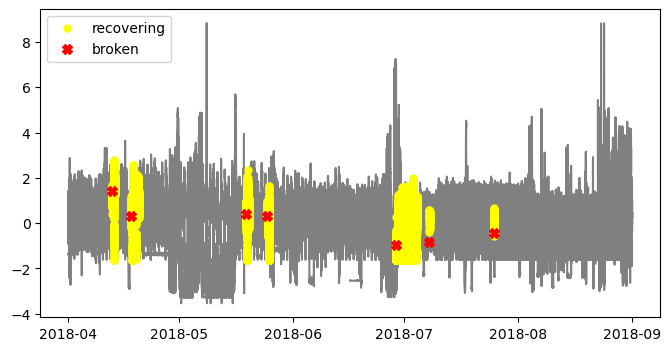

In [27]:

anomaly.plot_sensor(column=sensors[14:37])

The region around **'2018-05'** shows a **clear deviation** compared to the rest of the data, indicating a potential anomaly. However, the machine was reported to be **operating normally** when the sensors emitted these signals, suggesting that the detected deviation might be caused by **sensor noise or external factors** rather than an actual machine malfunction. We identified the following sensors as unreliable and conducted experiments by excluding them to assess their impact on overall performance.

## Anomaly Detection with clean Data

In [22]:
reduced_cols = sensors[:13]+sensors[37:]+['machine_status','timestamp']
reduced_df = df[reduced_cols]

In [23]:
anomaly_v2 = Anomaly(reduced_df)

                     sensor_00  sensor_01  sensor_02  sensor_03   sensor_04  \
timestamp                                                                     
2018-04-01 00:00:00   2.465394   47.09201  53.211800  46.310760  634.375000   
2018-04-01 00:01:00   2.465394   47.09201  53.211800  46.310760  634.375000   
2018-04-01 00:02:00   2.444734   47.35243  53.211800  46.397570  638.888900   
2018-04-01 00:03:00   2.460474   47.09201  53.168400  46.397568  628.125000   
2018-04-01 00:04:00   2.445718   47.13541  53.211800  46.397568  636.458300   
...                        ...        ...        ...        ...         ...   
2018-08-31 23:55:00   2.407350   47.69965  50.520830  43.142361  634.722229   
2018-08-31 23:56:00   2.400463   47.69965  50.564240  43.142361  630.902771   
2018-08-31 23:57:00   2.396528   47.69965  50.520830  43.142361  625.925903   
2018-08-31 23:58:00   2.406366   47.69965  50.520832  43.142361  635.648100   
2018-08-31 23:59:00   2.396528   47.69965  50.520832

/homes/rmeshita/Documents/Datascience-6/Unsupervised_learning/Anomaly_detection/anamoly.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['timestamp'] = pd.to_datetime(df['timestamp'])


#### Isolation Forest

In [24]:
X_train2, X_test2, y_train2, y_test2 = anomaly_v2.split_train_test()
X_train2, X_test2, y_train2, y_test2

(array([[ 2.38780265e-01,  6.52106564e-01,  9.48761070e-02, ...,
         -7.75709423e-01, -4.14271788e-01, -1.00343275e+00],
        [ 2.16786211e-01,  3.88571471e-01,  7.69597540e-01, ...,
         -3.35909951e-01, -4.59619424e-01, -1.45105424e-03],
        [ 6.03810161e-02, -6.26036932e-01,  4.61829199e-01, ...,
          9.41267143e-01,  5.22905766e-01,  5.33016922e-02],
        ...,
        [ 0.00000000e+00, -3.81480491e+00, -3.68117724e+00, ...,
         -1.44772293e+00, -1.32121836e+00,  7.54352566e+00],
        [ 3.26758963e-01, -1.40346276e+00, -3.66770950e-01, ...,
         -7.20301952e-02,  1.32404173e+00,  6.19996876e-01],
        [-8.70719631e-01,  7.04812516e-01,  6.51224510e-01, ...,
         -6.31455180e-01, -4.74735008e-01,  2.68907318e-16]]),
 array([[ 0.31698162, -0.15167454, -0.37861008, ..., -0.84959573,
         -0.38404044, -0.12464521],
        [ 0.32675896, -0.28344093, -0.08267815, ...,  0.47683955,
         -0.38404044, -0.18213606],
        [ 0.34386435, -0.

1.0


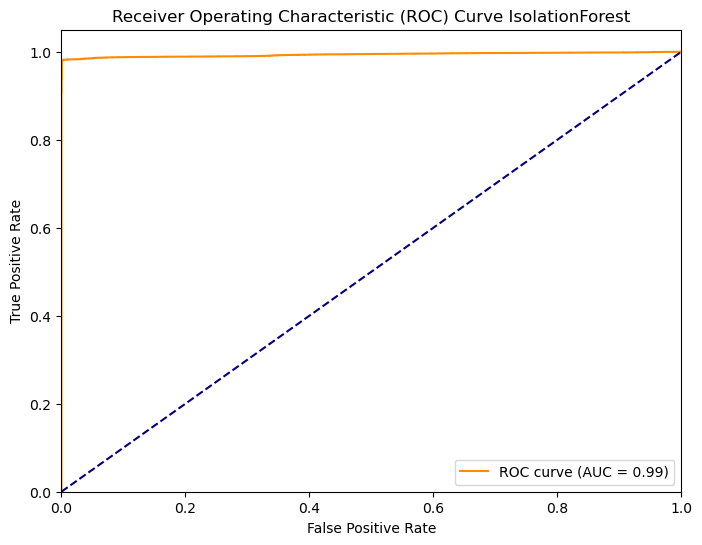

In [25]:
# with _train_test auc curve
anomaly.plot_auc_isolation_forest(isolation_forest, X_train2, y_test2, X_test2)

1.0


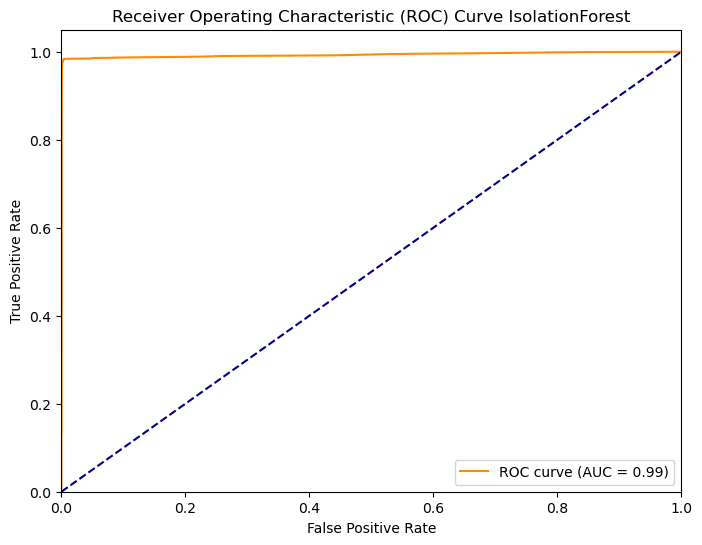

In [26]:
# without trains test with whole data
anomaly.plot_auc_isolation_forest(isolation_forest, anomaly_v2.X, anomaly_v2.return_target())

              precision    recall  f1-score   support

     Anomaly       0.81      0.81      0.81      2821
      Normal       0.99      0.99      0.99     41243

    accuracy                           0.98     44064
   macro avg       0.90      0.90      0.90     44064
weighted avg       0.98      0.98      0.98     44064



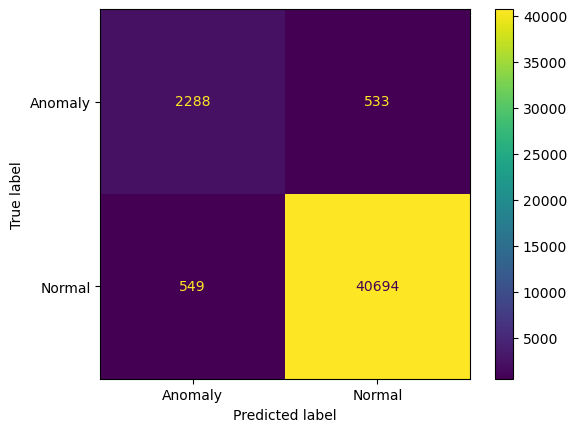

In [30]:
# with split evaluation 2
y_preds_split2  = anomaly_v2.anomaly_detection_with_train_test(isolation_forest,X_train2,X_test2)
y_preds_split2

anomaly_v2.evaluation(y_preds_split2, y_test2)

In [27]:
isolation_forest_preds_clean = anomaly_v2.anomaly_detection(isolation_forest)

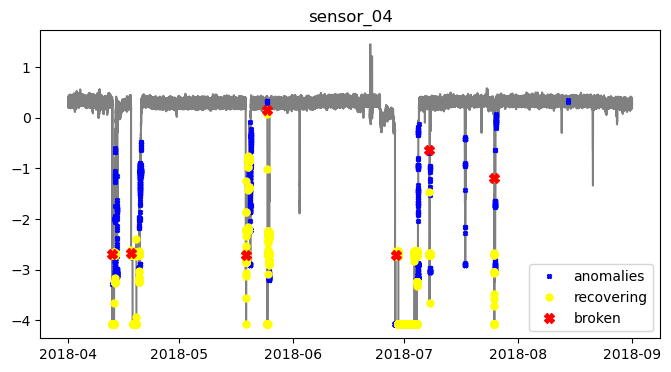

In [ ]:
anomaly_v2.plot_sensor(column = 'sensor_04', preds=isolation_forest_preds_clean)

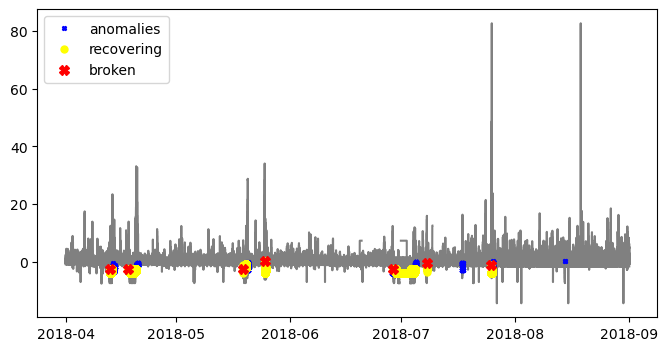

In [ ]:
anomaly_v2.plot_sensor(preds=isolation_forest_preds_clean)

              precision    recall  f1-score   support

     Anomaly       0.81      0.81      0.81     14484
      Normal       0.99      0.99      0.99    205836

    accuracy                           0.97    220320
   macro avg       0.90      0.90      0.90    220320
weighted avg       0.97      0.97      0.97    220320



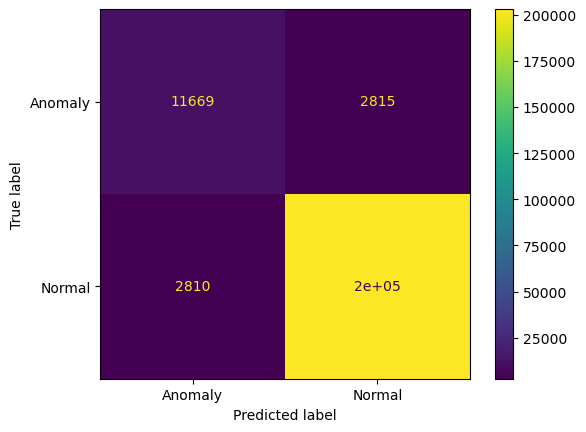

In [28]:
anomaly_v2.evaluation(isolation_forest_preds_clean)

The changes are very clear after removing unreliable sensors. Number of false positves reduced to 2692 from 10K. The f1 score for Anomaly is also improved from 0.26 to 0.81. (try to find papers on this algorithm and discuss why it has imporved so much)

#### SVM 

In [ ]:
svm_one_class_preds_clean = anomaly_v2.anomaly_detection(svm_one_class)

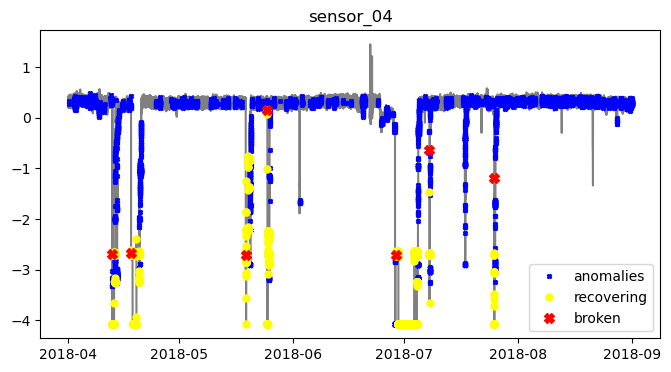

In [ ]:
anomaly_v2.plot_sensor(column = 'sensor_04',preds=svm_one_class_preds_clean)

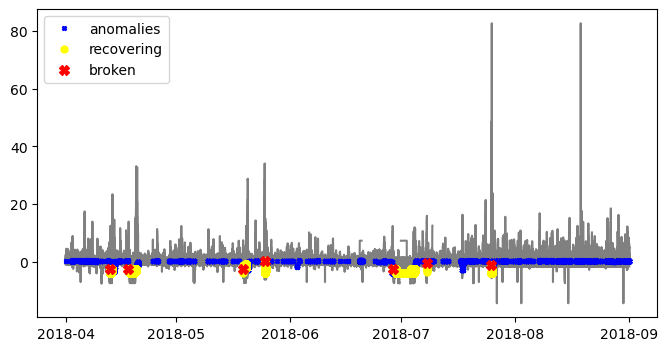

In [ ]:
anomaly_v2.plot_sensor(preds=svm_one_class_preds_clean)

              precision    recall  f1-score   support

     Anomaly       0.49      0.49      0.49     14484
      Normal       0.96      0.96      0.96    205836

    accuracy                           0.93    220320
   macro avg       0.73      0.73      0.73    220320
weighted avg       0.93      0.93      0.93    220320



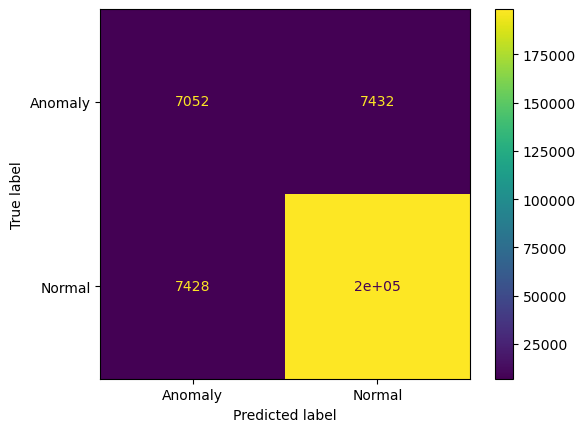

In [ ]:
anomaly_v2.evaluation(svm_one_class_preds_clean)

The changes are not very promising after removing unreliable sensors. Number of false positves reduced to 7428 from 8K. The f1 score for Anomaly is also improved from 0.42 to 0.49. (try to find papers on this algorithm and discuss why it has not imporved so much)

### Local Outlier Factor

In [ ]:
local_outliner_preds_clean = anomaly_v2.anomaly_detection(local_outliner, local_outlier=True)

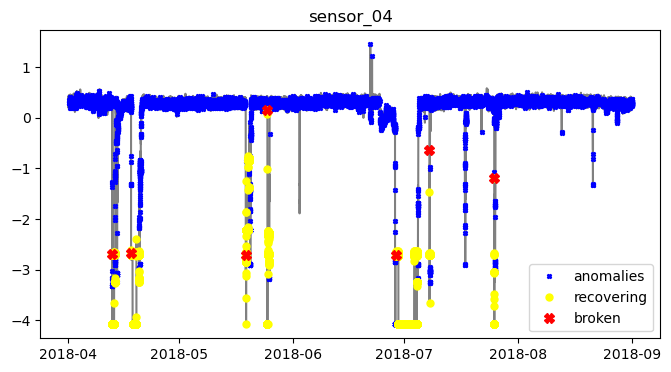

In [ ]:
anomaly_v2.plot_sensor(column = 'sensor_04',preds=local_outliner_preds_clean)

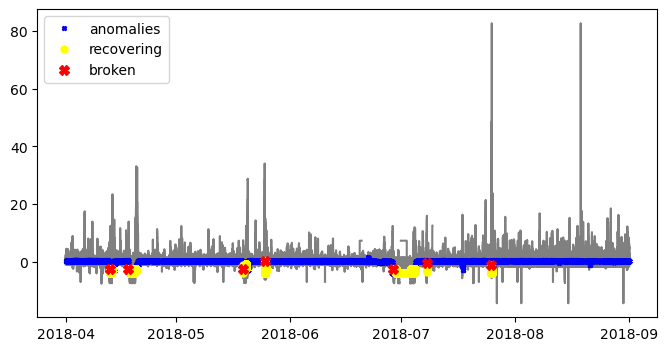

In [ ]:
anomaly_v2.plot_sensor(preds=local_outliner_preds_clean)

              precision    recall  f1-score   support

     Anomaly       0.21      0.21      0.21     14484
      Normal       0.94      0.94      0.94    205836

    accuracy                           0.90    220320
   macro avg       0.58      0.58      0.58    220320
weighted avg       0.90      0.90      0.90    220320



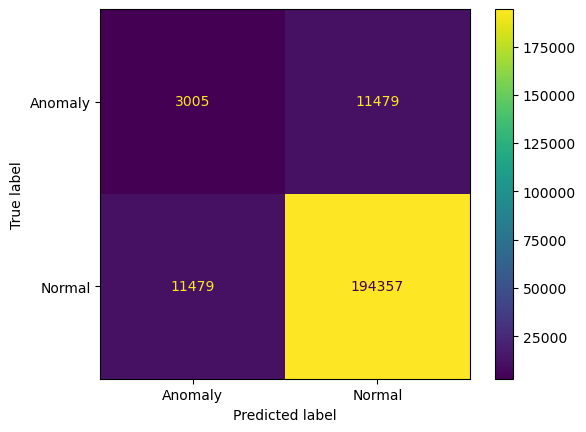

In [ ]:
anomaly_v2.evaluation(local_outliner_preds_clean)

The changes are not very promising after removing unreliable sensors. Number of false positves reduced to 11479 from 12K. The f1 score for Anomaly is also improved from 0.16 to 0.21. (try to find papers on this algorithm and discuss why it has not imporved so much)

### Robust covariance

In [ ]:
robust_covariance_preds_clean = anomaly_v2.anomaly_detection(robust_covariance)

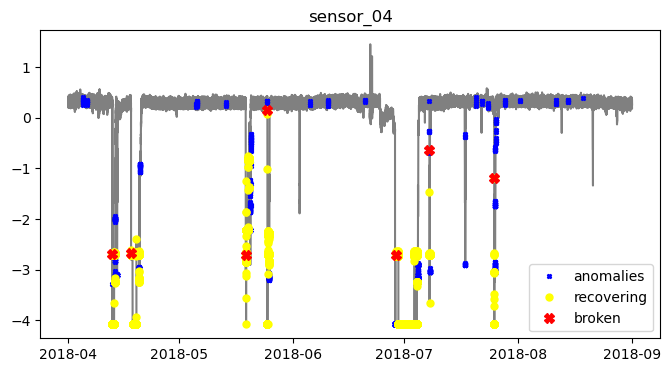

In [ ]:
anomaly_v2.plot_sensor(column = 'sensor_04',preds=robust_covariance_preds_clean)

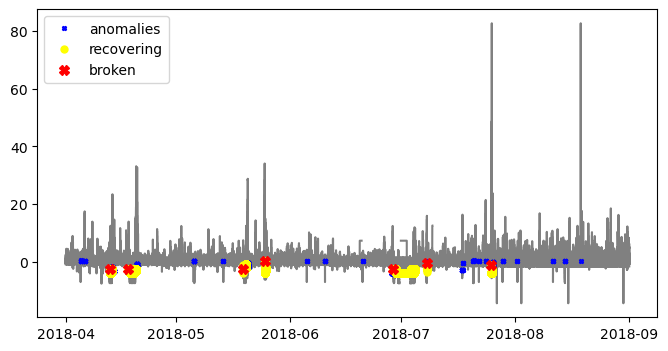

In [ ]:
anomaly_v2.plot_sensor(preds=robust_covariance_preds_clean)

              precision    recall  f1-score   support

     Anomaly       0.90      0.90      0.90     14484
      Normal       0.99      0.99      0.99    205836

    accuracy                           0.99    220320
   macro avg       0.95      0.95      0.95    220320
weighted avg       0.99      0.99      0.99    220320



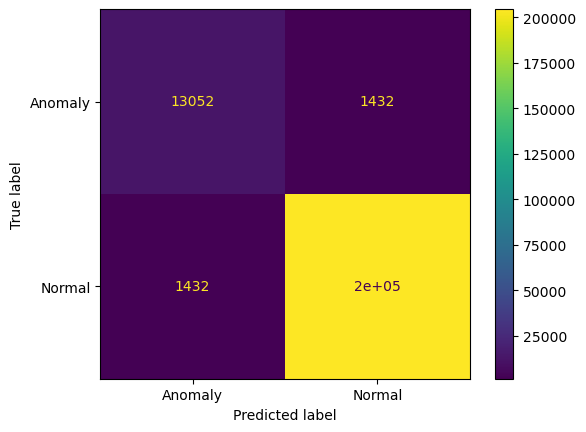

In [ ]:
anomaly_v2.evaluation(robust_covariance_preds_clean)

The changes are very promising after removing unreliable sensors. Number of false positves reduced to 1432 from 14K. The f1 score for Anomaly is also improved from 0.00 to 0.90 (try to find papers on this algorithm and discuss why it has imporved so much)

### Papers to read and cite appropriately. 

Like how did similar model performd in othere datasets, what evaluation metrics they used. First two used AUC, last one used F-score, however unsupervised algorithm models such as isolation forest doesn't predict probability values, hence it is not possible to plot AUC curves. So we used F1 score

- https://dl.acm.org/doi/pdf/10.14778/3538598.3538602
- https://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0152173&type=printable 
- https://sci-hub.se/10.1109/cybersecurity49315.2020.9138871